In [1]:
#https://pythonru.com/biblioteki/pyspark-dlja-nachinajushhih
#https://www.geeksforgeeks.org/pyspark-read-csv-file-into-dataframe/?ref=rp
#https://habr.com/ru/post/522296/  # ML - для спарка
#https://spark.apache.org/docs/latest/sql-ref-datatypes.html # datatypes
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.html #pyspark documentation
#https://translated.turbopages.org/proxy_u/en-ru.ru.d7c95c08-6287ba7f-e6de0b1b-74722d776562/https/stackoverflow.com/questions/62179853/how-to-parallelize-my-file-processing-program-using-pyspark
#- для паралельных вычислений используй def NAME()!! потом попробуй  NAME.map(transform_to_parquet) 

# Import all libraries | Импортируем все необходимые библиотеки

In [2]:
import os # для создания списков с которыми работаем
import socket
import operator
from collections import Counter, OrderedDict
from jinja2 import Environment, FileSystemLoader
#Для первоначальное обработки файлов pandas (без него никак)
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns




#импортируем необходимые библиотеки
from pyspark.sql.functions import countDistinct
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as sf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.regression import GBTRegressor

#Библы для машинного обучения
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
path_to_files = 'BIG_DATA_ALL_files'
#path_to_files = 'BIG_DATA_ALL_files_test'

# Run spark session

In [4]:
# setting constants
APP_NAME = "Big_Data_Project_test"
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = "-Dlog4j.configuration=file://{} -Dspark.hadoop.dfs.replication=1 -Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"\
    .format(LOG4J_PROP_FILE)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [5]:
# preparing configuration files from templates
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template\
    .stream(logfile=LOG_FILE)\
    .dump(LOG4J_PROP_FILE)

In [6]:
#Создаем spark сессию на локальном мастере (?)
# run spark
spark = SparkSession\
    .builder\
    .appName(APP_NAME)\
    .master("k8s://https://10.32.7.103:6443")\
    .config("spark.driver.host", LOCAL_IP)\
    .config("spark.ui.port", "4040")\
    .config("spark.kubernetes.memoryOverheadFactor", "0.6")\
    .config("spark.driver.memory", "4g")\
    .config("spark.driver.bindAddress", "0.0.0.0")\
    .config("spark.executor.instances", "5")\
    .config("spark.executor.cores", '1')\
    .config("spark.executor.memory", "3g")\
    .config("spark.memory.fraction", "0.6")\
    .config("spark.memory.storageFraction", "0.5")\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)\
    .config("spark.kubernetes.namespace", "asamofalov-338269")\
    .config("spark.kubernetes.driver.label.appname", APP_NAME)\
    .config("spark.kubernetes.executor.label.appname", APP_NAME)\
    .config("spark.kubernetes.container.image.pullPolicy", "Always")\
    .config("spark.kubernetes.container.image", "node03.st:5000/spark-executor:asamofalov-338269")\
    .config("spark.kubernetes.executor.deleteOnTermination", "true")\
    .config("spark.local.dir", "/tmp/spark")\
    .getOrCreate()

In [7]:
spark

# Пишем функцию для предобработки файлов при помощи pandas + pyspark и записываем все файлы в HDFS - Александр

In [8]:
#Определяем список аэропортов прибытия из названия папок
df_airport_lists = []
for i in os.listdir(path_to_files):
  df_airport_lists.append(i)

#Определяем путь к всем файлам csv из разных папок с в df_link_list
df_link_list = []
for i in df_airport_lists:
  path_i = path_to_files + '/' + i
  for file_name in os.listdir(path_i):
      df_link_list.append(path_i + '/' + file_name)

In [9]:
#переименовываем название файлов в папках для нормальной работы
for i in range(len(df_link_list)):
    airport = df_link_list[i].split('/')[1]
    name = 'Detailed_Statistics_Arrivals_'+str(i)+'_'+airport
    path = df_link_list[i].split('/')[0]
    os.rename(df_link_list[i],path+'/'+airport+'/'+name+'.csv')

In [10]:
#Смотрим лист с всеми путями до csv в jupyter окружении
df_link_list

['BIG_DATA_ALL_files/PIT/Detailed_Statistics_Arrivals_1_PIT.csv',
 'BIG_DATA_ALL_files/PIT/Detailed_Statistics_Arrivals_0_PIT.csv',
 'BIG_DATA_ALL_files/PIT/Detailed_Statistics_Arrivals_2_PIT.csv',
 'BIG_DATA_ALL_files/BOS/Detailed_Statistics_Arrivals_5_BOS.csv',
 'BIG_DATA_ALL_files/BOS/Detailed_Statistics_Arrivals_4_BOS.csv',
 'BIG_DATA_ALL_files/BOS/Detailed_Statistics_Arrivals_3_BOS.csv',
 'BIG_DATA_ALL_files/BOS/Detailed_Statistics_Arrivals_6_BOS.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_11_DEN.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_13_DEN.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_9_DEN.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_7_DEN.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_10_DEN.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_12_DEN.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_14_DEN.csv',
 'BIG_DATA_ALL_files/DEN/Detailed_Statistics_Arrivals_16_DEN.csv',
 'BI

In [11]:
my_rdd = spark.sparkContext.parallelize(df_link_list) #как правильно засунуть сюда data?

In [12]:
#my_rdd.collect()

In [14]:
# код для обработки файлов по всем csv via pandas
# import pandas as pd # - исключительно для предобработки dataframe в читабильный вид
# df_new = df.drop(labels='Tail Number',axis=1)

# def f_test(x): #
#     path_to_csv = x #[i] # надо узнать путь до csv из переданного списка
#     Destination_Airport = path_to_csv.split('/')[1]
#     df_temp = pd.read_csv(path_to_csv, skiprows=7, skipfooter=7)
#     df_temp = df.drop(labels='Tail Number',axis=1)
#     df_temp['Destination Airport'] = Destination_Airport
#     df_temp.to_csv(path_to_csv, index=False)
    
# my_rdd.foreach(f_test) #выполняем обработку файлов по всем csv через функцию f_test

In [15]:
#записываем файлы на hdfs - https://kublr.com/blog/running-spark-with-jupyter-notebook-hdfs-on-kubernetes/

# for x in df_link_list: #
#     try:
#         path_to_csv = x #[i] # надо узнать путь до csv из переданного списка
#         file_name = path_to_csv.split('/')[2]
#         df_temp = pd.read_csv(path_to_csv)
#         df_new = df_temp.drop(labels='Tail Number',axis=1)    
#         data_spark_temp = spark.createDataFrame(df_new)
#         data_spark_temp.write.csv("/home/asamofalov-338269/BIG_DATA_ALL_files/" + file_name)
#     except:
#         pass

In [16]:
#создаем новый df_link_list который ведет в HDFS

new_path_list = []
for i in range(len(df_link_list)):
    file_name = df_link_list[i].split('/')[2]
    temp_name = '/home/asamofalov-338269/BIG_DATA_ALL_files/'
    new_path_list.append(temp_name + file_name)

In [17]:
#Смотрим какие файлы у нас на HDFS в папке с BIG_DATA_ALL_files
#Все файлы имеют флаг drwxr-xr-x

#new_path_list **** - содержит путь до всех этих файлов

In [18]:
!hadoop fs -ls /home/asamofalov-338269/BIG_DATA_ALL_files/

Found 101 items
drwxr-xr-x   - asamofalov-338269 asamofalov-338269          0 2022-05-26 23:49 /home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_0_PIT.csv
drwxr-xr-x   - asamofalov-338269 asamofalov-338269          0 2022-05-27 00:07 /home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_10_DEN.csv
drwxr-xr-x   - asamofalov-338269 asamofalov-338269          0 2022-05-27 00:07 /home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_11_DEN.csv
drwxr-xr-x   - asamofalov-338269 asamofalov-338269          0 2022-05-27 00:07 /home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_12_DEN.csv
drwxr-xr-x   - asamofalov-338269 asamofalov-338269          0 2022-05-27 00:07 /home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_13_DEN.csv
drwxr-xr-x   - asamofalov-338269 asamofalov-338269          0 2022-05-27 00:07 /home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_14_DEN.csv
drwxr-xr-x   

# Инициализируем запуск pyspark dataframe файлов из HDFS - Александр

In [19]:
#Подготовка к чтению файлов
first_schema = [
               StructField('Carrier Code', StringType(), True),
               StructField('Date (MM/DD/YYYY)', StringType(), True),
               StructField('Flight Number', StringType(), True),
               StructField('Origin Airport', StringType(), True),
               StructField('Scheduled Arrival Time', StringType(), True),
               StructField('Actual Arrival Time', StringType(), True),
               StructField('Scheduled Elapsed Time (Minutes)', DoubleType(), True),
               StructField('Actual Elapsed Time (Minutes)', DoubleType(), True),
               StructField('Arrival Delay (Minutes)', DoubleType(), True),
               StructField('Wheels-on Time', StringType(), True),
               StructField('Taxi-In time (Minutes)', DoubleType(), True),
               StructField('Delay Carrier (Minutes)', DoubleType(), True),
               StructField('Delay Weather (Minutes', DoubleType(), True),
               StructField('Delay National Aviation System (Minutes)', DoubleType(), True),
               StructField('Delay Security (Minutes)', DoubleType(), True),
               StructField('Delay Late Aircraft Arrival (Minutes)', DoubleType(), True),
               StructField('Destination Airport', StringType(), True), 
            ]


final_struc = StructType(fields = first_schema)

In [20]:
general_df = spark.read.csv(new_path_list, schema=final_struc, header = True) #final_struc

In [21]:
new_path_list

['/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_1_PIT.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_0_PIT.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_2_PIT.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_5_BOS.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_4_BOS.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_3_BOS.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_6_BOS.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_11_DEN.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_13_DEN.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_9_DEN.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detailed_Statistics_Arrivals_7_DEN.csv',
 '/home/asamofalov-338269/BIG_DATA_ALL_files/Detaile

In [22]:
#Смотрим как выглядит датафрейм
general_df.limit(5).toPandas()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes,Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Destination Airport
0,MQ,06/29/2019,4142,GJT,09:08,08:52,127.0,118.0,-16.0,08:46,6.0,0.0,0.0,0.0,0.0,0.0,DFW
1,MQ,06/29/2019,4145,FCA,16:38,16:12,214.0,196.0,-26.0,16:07,5.0,0.0,0.0,0.0,0.0,0.0,DFW
2,MQ,06/29/2019,4148,ABI,14:47,14:30,62.0,54.0,-17.0,14:18,12.0,0.0,0.0,0.0,0.0,0.0,DFW
3,MQ,06/29/2019,4150,GCK,15:39,16:37,86.0,75.0,58.0,16:31,6.0,0.0,46.0,0.0,0.0,12.0,DFW
4,MQ,06/29/2019,4151,GPT,21:16,22:25,105.0,96.0,69.0,22:18,7.0,0.0,41.0,0.0,0.0,28.0,DFW


In [23]:
#Какие вообще колонки у нас есть в dataframe?
general_df_columns = general_df.schema.names
print(general_df_columns)

['Carrier Code', 'Date (MM/DD/YYYY)', 'Flight Number', 'Origin Airport', 'Scheduled Arrival Time', 'Actual Arrival Time', 'Scheduled Elapsed Time (Minutes)', 'Actual Elapsed Time (Minutes)', 'Arrival Delay (Minutes)', 'Wheels-on Time', 'Taxi-In time (Minutes)', 'Delay Carrier (Minutes)', 'Delay Weather (Minutes', 'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)', 'Destination Airport']


In [24]:
#Схема dataframe с значением типа колонок
general_df.printSchema()

root
 |-- Carrier Code: string (nullable = true)
 |-- Date (MM/DD/YYYY): string (nullable = true)
 |-- Flight Number: string (nullable = true)
 |-- Origin Airport: string (nullable = true)
 |-- Scheduled Arrival Time: string (nullable = true)
 |-- Actual Arrival Time: string (nullable = true)
 |-- Scheduled Elapsed Time (Minutes): double (nullable = true)
 |-- Actual Elapsed Time (Minutes): double (nullable = true)
 |-- Arrival Delay (Minutes): double (nullable = true)
 |-- Wheels-on Time: string (nullable = true)
 |-- Taxi-In time (Minutes): double (nullable = true)
 |-- Delay Carrier (Minutes): double (nullable = true)
 |-- Delay Weather (Minutes: double (nullable = true)
 |-- Delay National Aviation System (Minutes): double (nullable = true)
 |-- Delay Security (Minutes): double (nullable = true)
 |-- Delay Late Aircraft Arrival (Minutes): double (nullable = true)
 |-- Destination Airport: string (nullable = true)



In [25]:
#Доп. задача. Разобраться с типом данных для каждого столбца* Максим?

# Статистика по данным из разных csv - Максим, Дима

In [26]:
#Задача №1. Вывести уникальные значения всех аэропортов вылета Origin Airport и аэропортов прибытия Destination Airport / print()
task_oa = general_df.select('Origin Airport')
print('Уникальные значения столбца Origin Airport')
task_oa.distinct().show()
task_oa.select(countDistinct('Origin Airport').alias('amount')).show()


task_da = general_df.select('Destination Airport')
print('Уникальные значения столбца Destination Airport')
task_da.distinct().show()
task_da.select(countDistinct('Destination Airport').alias('amount')).show()

Уникальные значения столбца Origin Airport
+--------------+
|Origin Airport|
+--------------+
|           MSY|
|           GEG|
|           DRT|
|           BUR|
|           SNA|
|           GRB|
|           GTF|
|           FOD|
|           IDA|
|           GRR|
|           JLN|
|           EUG|
|           ATY|
|           MYR|
|           GSO|
|           PVD|
|           OAK|
|           EAR|
|           MSN|
|           FAR|
+--------------+
only showing top 20 rows

+------+
|amount|
+------+
|   274|
+------+

Уникальные значения столбца Destination Airport
+-------------------+
|Destination Airport|
+-------------------+
|                 LA|
|                DCA|
|                IAH|
|                TUL|
|                BOS|
|                DEN|
|                SEA|
|                BWI|
|                TPA|
|                DFW|
|                SFO|
|                 LV|
|                VPS|
|                ILM|
|                PIT|
|                TUS|
|          

In [27]:
data_oa = general_df.groupBy('Origin Airport').count().sort('count')
data_oa.toPandas()

,Origin Airport,count
0,MCN,1
1,CDV,3
2,GUM,11
3,BTM,55
4,BIH,58
...,...,...
269,SFO,438843
270,ATL,455615
271,LAX,547747
272,ORD,937809


In [28]:
oa = list(data_oa.select('Origin Airport').toPandas()['Origin Airport'])[::-20] #два раза в один датасет
count_oa = list(data_oa.select('count').toPandas()['count'])[::-20]

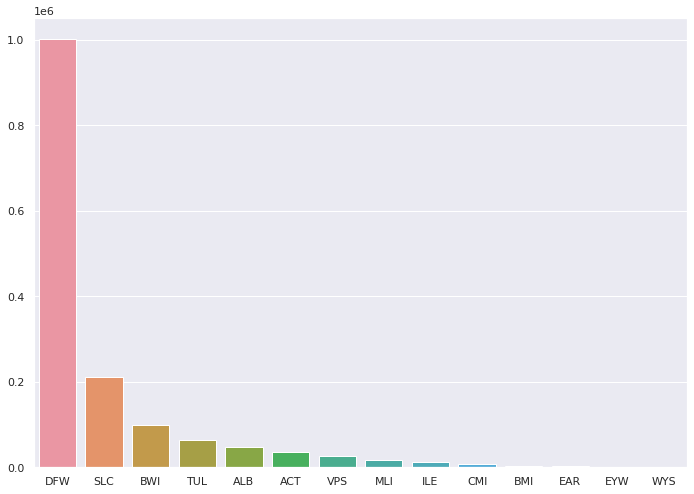

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=oa, y=count_oa)
plt.show()

In [30]:
data_da = general_df.groupBy('Destination Airport').count()
data_da.toPandas()

,Destination Airport,count
0,LA,989607
1,DCA,825433
2,IAH,1118806
3,TUL,105544
4,BOS,574826
5,DEN,1563687
6,SEA,1246625
7,TPA,367695
8,BWI,1414259
9,DFW,3887085


In [31]:
da = list(data_da.select('Destination Airport').toPandas()['Destination Airport'])
count_da =list(data_da.select('count').toPandas()['count'])

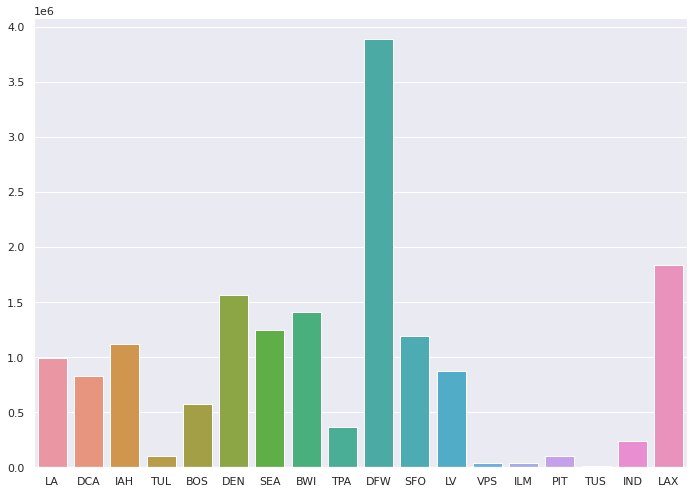

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=da, y=count_da)
plt.show()

In [33]:
#Задача №2. Вывести уникальные значения всех Carrier Code / print()
print('Уникальные значения столбца Carrier Code')
data_task_2 = general_df.select('Carrier Code').distinct()
data_task_2.show()
data_task_2.select(countDistinct('Carrier Code').alias('amount')).show()

Уникальные значения столбца Carrier Code
+------------+
|Carrier Code|
+------------+
|          UA|
|          NK|
|          AA|
|          NW|
|          EV|
|          HP|
|          DL|
|          OO|
|          F9|
|          YV|
|          TZ|
|          US|
|          MQ|
|          HA|
|          XE|
|          YX|
|          DH|
|          AS|
|          CO|
|          FL|
+------------+
only showing top 20 rows

+------+
|amount|
+------+
|    23|
+------+



In [34]:
#Задача №3. Вывести кол.во рейсов с опозданием по каждому Carrier Code. / наименование Carrier code и кол-во рейсов (лучше если получится гистограмма)
data = general_df.groupBy('Carrier Code').count()
data.toPandas()

,Carrier Code,count
0,UA,3162470
1,NK,182431
2,AA,3022180
3,NW,13213
4,EV,533961
5,HP,142119
6,DL,717469
7,OO,1096533
8,F9,50270
9,YV,27596


In [35]:
code = list(data.select('Carrier Code').toPandas()['Carrier Code'])
count = list(data.select('count').toPandas()['count'])

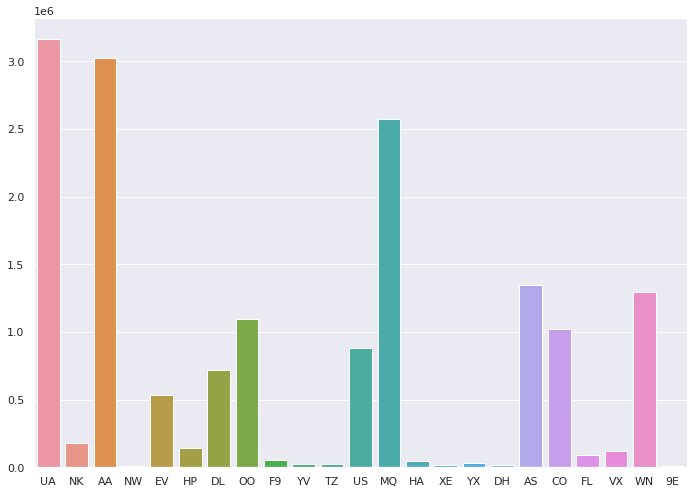

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=code, y=count)
plt.show()

In [37]:
#Задача №5. Узнать среднее значение, моду, max и min по столбцу с 'Arrival Delay (Minutes)'
general_df.describe(['Arrival Delay (Minutes)']).show()
print('mode: ', general_df.groupby("Arrival Delay (Minutes)").count().orderBy("count", ascending=False).first())

+-------+-----------------------+
|summary|Arrival Delay (Minutes)|
+-------+-----------------------+
|  count|               16428326|
|   mean|      4.239788643103381|
| stddev|     38.825976104180064|
|    min|                 -942.0|
|    max|                 2302.0|
+-------+-----------------------+

mode:  Row(Arrival Delay (Minutes)=0.0, count=741891)


In [38]:
#Задача №4. Перевести столбец 'Date (MM/DD/YYYY)' в timestamp и провести показательную индексацию dataframe
#Индексация в период с 2020 по 2022 год, показать dataframe >> general_df.limit(5).toPandas() и указать кол-во рейсов за эти два года
func_date =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
full_df =  general_df.withColumn('Date', func_date(col('Date (MM/DD/YYYY)'))).drop('Date (MM/DD/YYYY)')

In [39]:
deep_night, morning, afternoon, evening  = spark.sparkContext.broadcast(list(range(0,5))),\
spark.sparkContext.broadcast(list(range(5,11))),\
spark.sparkContext.broadcast(list(range(11,17))),\
spark.sparkContext.broadcast(list(range(17,22)))
#используем broadcast как глобальный лист для workers

def times_of_day(x):
    h = int(x[:2])
    if h in deep_night.value:
        return 'deep night'
    
    elif h in morning.value:
        return 'morning'
    
    elif h in afternoon.value:
        return 'afternoon'
    
    elif h in evening.value:
        return 'evening'
    
    else:
        return 'night'
    
func_times = udf(lambda x: times_of_day(x), StringType())    

In [40]:
full_df =  full_df.withColumn('Scheduled Arrival Time (Times of day)', func_times(col('Scheduled Arrival Time')))

In [41]:
winter, spring, summer = spark.sparkContext.broadcast([1,2,12]),\
spark.sparkContext.broadcast([3,4,5]),\
spark.sparkContext.broadcast([6,7,8])
#используем broadcast как глобальный лист для workers

def season(x):
    if x.month in winter.value:
        return 'winter'
    
    elif x.month in spring.value:
        return 'spring'
    
    elif x.month in summer.value:
        return 'summer'
    
    else:
        return 'autumn'
    
func_season = udf(lambda x: season(x), StringType())    

In [42]:
full_df =  full_df.withColumn('Date (season)', func_season(col('Date')))

In [43]:
#Это для того чтобы показать работы метода filter 
full_df.filter((full_df.Date >= datetime(2021, 5, 1))    &    (full_df.Date <= datetime(2022, 12, 31))).limit(5).toPandas()

,Carrier Code,Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes,Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Destination Airport,Date,Scheduled Arrival Time (Times of day),Date (season)
0,MQ,3500,GCK,07:29,07:18,89.0,80.0,-11.0,07:09,9.0,0.0,0.0,0.0,0.0,0.0,DFW,2021-06-29,morning,summer
1,MQ,3502,HHH,18:10,18:22,168.0,175.0,12.0,18:18,4.0,0.0,0.0,0.0,0.0,0.0,DFW,2021-06-29,evening,summer
2,MQ,3503,BUF,18:01,17:52,196.0,193.0,-9.0,17:38,14.0,0.0,0.0,0.0,0.0,0.0,DFW,2021-06-29,evening,summer
3,MQ,3506,EVV,16:54,16:34,129.0,112.0,-20.0,16:19,15.0,0.0,0.0,0.0,0.0,0.0,DFW,2021-06-29,afternoon,summer
4,MQ,3527,XNA,08:40,08:15,85.0,65.0,-25.0,08:09,6.0,0.0,0.0,0.0,0.0,0.0,DFW,2021-06-29,morning,summer


In [44]:
full_df.limit(5).toPandas()

,Carrier Code,Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes,Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Destination Airport,Date,Scheduled Arrival Time (Times of day),Date (season)
0,MQ,4142,GJT,09:08,08:52,127.0,118.0,-16.0,08:46,6.0,0.0,0.0,0.0,0.0,0.0,DFW,2019-06-29,morning,summer
1,MQ,4145,FCA,16:38,16:12,214.0,196.0,-26.0,16:07,5.0,0.0,0.0,0.0,0.0,0.0,DFW,2019-06-29,afternoon,summer
2,MQ,4148,ABI,14:47,14:30,62.0,54.0,-17.0,14:18,12.0,0.0,0.0,0.0,0.0,0.0,DFW,2019-06-29,afternoon,summer
3,MQ,4150,GCK,15:39,16:37,86.0,75.0,58.0,16:31,6.0,0.0,46.0,0.0,0.0,12.0,DFW,2019-06-29,afternoon,summer
4,MQ,4151,GPT,21:16,22:25,105.0,96.0,69.0,22:18,7.0,0.0,41.0,0.0,0.0,28.0,DFW,2019-06-29,evening,summer


In [45]:
full_df.groupBy('Date (season)').count().toPandas()

,Date (season),count
0,winter,4020545
1,summer,4309416
2,spring,4101564
3,autumn,3996801


In [46]:
full_df.groupBy('Scheduled Arrival Time (Times of day)').count().toPandas()

,Scheduled Arrival Time (Times of day),count
0,afternoon,5788324
1,night,1168157
2,deep night,224207
3,morning,4108942
4,evening,5138696


# Подготовка данных для части с машинным обучением - Максим и Ильдар

In [47]:
#Задача №1. Подготовить новый dataframe со-всеми необходимыми столбцами (лишние удалить) и применить ван-хот кодинг к
#..к Original Airport, Destination ,Airport, Carrier Code. || Не трогай столбец с наименованием Arrival Delay (Minutes)!!
inputColumns = ['Origin Airport', 'Destination Airport', 'Carrier Code', 
              'Scheduled Arrival Time (Times of day)', 'Date (season)']

indexColumns = ['Origin Airport Index', 'Destination Airport Index', 'Carrier Code Index', 
              'Scheduled Arrival Time (Times of day) Index', 'Date (season) Index']

oneColumns = ['Origin Airport Vector', 'Destination Airport Vector', 'Carrier Code Vector', 
              'Scheduled Arrival Time (Times of day) Vector', 'Date (season) Vector']

indexer = StringIndexer(inputCols = inputColumns, outputCols = indexColumns) #что с indexer по for inputcols
full_df = indexer.fit(full_df).transform(full_df)
vector = OneHotEncoder(inputCols = indexColumns, outputCols = oneColumns)
full_df = vector.fit(full_df).transform(full_df)


In [48]:
#Задача №2. Приведи колонки с Delay_Carrie, Delay_Weather, Delay National
#Aviation system, Delay Secutiry and Delay Late aircraft arrival(minuttes) >> к бинарному выводу 0 и 1 (0 в случае если не является причиной задержки)
full_df = full_df.withColumn('Delay Carrier (binary)', 
                          when(col('Delay Carrier (Minutes)') > 0, 1).otherwise(0)).\
                          withColumn('Delay Weather (binary)', 
                          when(col('Delay Weather (Minutes') > 0, 1).otherwise(0)).\
                          withColumn('Delay National Aviation System (binary)', 
                          when(col('Delay National Aviation System (Minutes)') > 0, 1).otherwise(0)).\
                          withColumn('Delay Security (binary)', 
                          when(col('Delay Security (Minutes)') > 0, 1).otherwise(0)).\
                          withColumn('Delay Late Aircraft Arrival (binary)', 
                          when(col('Delay Late Aircraft Arrival (Minutes)') > 0, 1).otherwise(0))

In [49]:
full_df.printSchema()

root
 |-- Carrier Code: string (nullable = true)
 |-- Flight Number: string (nullable = true)
 |-- Origin Airport: string (nullable = true)
 |-- Scheduled Arrival Time: string (nullable = true)
 |-- Actual Arrival Time: string (nullable = true)
 |-- Scheduled Elapsed Time (Minutes): double (nullable = true)
 |-- Actual Elapsed Time (Minutes): double (nullable = true)
 |-- Arrival Delay (Minutes): double (nullable = true)
 |-- Wheels-on Time: string (nullable = true)
 |-- Taxi-In time (Minutes): double (nullable = true)
 |-- Delay Carrier (Minutes): double (nullable = true)
 |-- Delay Weather (Minutes: double (nullable = true)
 |-- Delay National Aviation System (Minutes): double (nullable = true)
 |-- Delay Security (Minutes): double (nullable = true)
 |-- Delay Late Aircraft Arrival (Minutes): double (nullable = true)
 |-- Destination Airport: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Scheduled Arrival Time (Times of day): string (nullable = true)
 |-- Date (seas

In [50]:
full_df.limit(5).toPandas()

,Carrier Code,Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),...,Origin Airport Vector,Carrier Code Vector,Scheduled Arrival Time (Times of day) Vector,Destination Airport Vector,Date (season) Vector,Delay Carrier (binary),Delay Weather (binary),Delay National Aviation System (binary),Delay Security (binary),Delay Late Aircraft Arrival (binary)
0,MQ,4142,GJT,09:08,08:52,127.0,118.0,-16.0,08:46,6.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",0,0,0,0,0
1,MQ,4145,FCA,16:38,16:12,214.0,196.0,-26.0,16:07,5.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",0,0,0,0,0
2,MQ,4148,ABI,14:47,14:30,62.0,54.0,-17.0,14:18,12.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",0,0,0,0,0
3,MQ,4150,GCK,15:39,16:37,86.0,75.0,58.0,16:31,6.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",0,1,0,0,1
4,MQ,4151,GPT,21:16,22:25,105.0,96.0,69.0,22:18,7.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)",0,1,0,0,1


## Корреляция

In [51]:
corrColumns =  ['Delay Carrier (binary)',
                'Delay Weather (binary)',
                'Delay National Aviation System (binary)',
                'Delay Security (binary)',
                'Delay Late Aircraft Arrival (binary)',
                'Origin Airport Index',
                'Destination Airport Index',
                'Carrier Code Index',
                'Scheduled Arrival Time (Times of day) Index',
                'Date (season) Index',
                'Arrival Delay (Minutes)',
          ]

corr_df = full_df.select(corrColumns)
assembler = VectorAssembler(inputCols=corr_df.columns, 
                            outputCol="features",
                            handleInvalid='keep')
corr = assembler.transform(corr_df).select("features")
correlation = Correlation.corr(corr, "features", "spearman").collect()[0][0]
rows = correlation.toArray().tolist()
corr = spark.createDataFrame(rows, corr_df.columns).toPandas()
corr.index = corrColumns

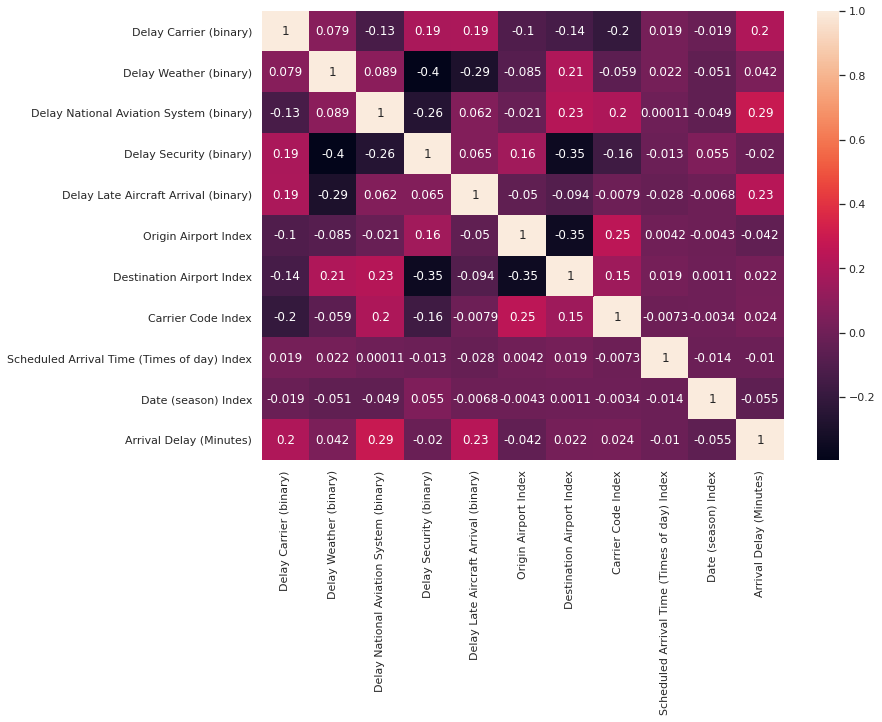

In [52]:
sns.heatmap(corr, annot=True)
plt.show()

Чтобы поменять нужные столбцы, меняйте массив columns и прогоняйте следующий блок 

In [53]:
columns = [ 'Delay Carrier (binary)',
            'Delay Weather (binary)',
            'Delay National Aviation System (binary)',
            'Delay Security (binary)',
            'Delay Late Aircraft Arrival (binary)',

            'Origin Airport Vector',
            'Destination Airport Vector',
            'Carrier Code Vector',
            'Scheduled Arrival Time (Times of day) Vector',
            'Date (season) Vector',
           
            'Arrival Delay (Minutes)',
          ]
df = full_df.select(columns)

In [54]:
df.printSchema()

root
 |-- Delay Carrier (binary): integer (nullable = false)
 |-- Delay Weather (binary): integer (nullable = false)
 |-- Delay National Aviation System (binary): integer (nullable = false)
 |-- Delay Security (binary): integer (nullable = false)
 |-- Delay Late Aircraft Arrival (binary): integer (nullable = false)
 |-- Origin Airport Vector: vector (nullable = true)
 |-- Destination Airport Vector: vector (nullable = true)
 |-- Carrier Code Vector: vector (nullable = true)
 |-- Scheduled Arrival Time (Times of day) Vector: vector (nullable = true)
 |-- Date (season) Vector: vector (nullable = true)
 |-- Arrival Delay (Minutes): double (nullable = true)



In [55]:
df.limit(5).toPandas()

,Delay Carrier (binary),Delay Weather (binary),Delay National Aviation System (binary),Delay Security (binary),Delay Late Aircraft Arrival (binary),Origin Airport Vector,Destination Airport Vector,Carrier Code Vector,Scheduled Arrival Time (Times of day) Vector,Date (season) Vector,Arrival Delay (Minutes)
0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0)",-16.0
1,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",-26.0
2,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",-17.0
3,0,1,0,0,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",58.0
4,0,1,0,0,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",69.0


Далее в работе используйте df

In [56]:
df.columns

['Delay Carrier (binary)',
 'Delay Weather (binary)',
 'Delay National Aviation System (binary)',
 'Delay Security (binary)',
 'Delay Late Aircraft Arrival (binary)',
 'Origin Airport Vector',
 'Destination Airport Vector',
 'Carrier Code Vector',
 'Scheduled Arrival Time (Times of day) Vector',
 'Date (season) Vector',
 'Arrival Delay (Minutes)']

In [57]:
#==========================
#Задача для Ильдара - №1: Разбить столбцы на обучающую и тренеровочную выборку 
#(нужно ли использовать RDD тут как-то?)
ycolumns = ['Arrival Delay (Minutes)']
xcolumns = ['Delay Carrier (binary)',
            'Delay Weather (binary)',
            'Delay National Aviation System (binary)',
            'Delay Security (binary)',
            'Delay Late Aircraft Arrival (binary)',
            'Origin Airport Vector',  
            'Destination Airport Vector', 
            'Carrier Code Vector', 
            'Scheduled Arrival Time (Times of day) Vector',
            'Date (season) Vector'
         ]

In [58]:
lrcolumns = ['Arrival Delay (Minutes)',
            
            'Delay Carrier (binary)',
            'Delay Weather (binary)',
            'Delay National Aviation System (binary)',
            'Delay Security (binary)',
            'Delay Late Aircraft Arrival (binary)',
            'Origin Airport Vector', 
            'Destination Airport Vector', 
            'Carrier Code Vector',
            'Scheduled Arrival Time (Times of day) Vector',
            'Date (season) Vector'
         ]

## Машинное обучение - Ильдар и Александр

In [59]:
#Описание задачи 1: обучить модель ML предсказывать время на которое опоздает рейс по колонке 
#'Arrival Delay (Minutes)' исходя из столбцов Origin Airport, Destination Airport, 
#Carrier Code, Delay Carrier (binary)', 'Delay Weather (binary)', 'Delay National Aviation System (Binary)', 
#'Delay Security (binary)', 'Delay Late Aircraft Arrival (binary)'

# LinearRegression

In [60]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [61]:
assembler = VectorAssembler(inputCols=xcolumns, outputCol='features')
output = assembler.transform(df.select(lrcolumns))

In [62]:
train, test = output.randomSplit([0.8, 0.2])

In [63]:
%%time
lr = LinearRegression(featuresCol='features', 
                      labelCol='Arrival Delay (Minutes)')
lr_model = lr.fit(train)

CPU times: user 17.7 ms, sys: 4.45 ms, total: 22.1 ms
Wall time: 1min 50s


In [64]:
lr_predictions = lr_model.transform(test)

In [65]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(labelCol='Arrival Delay (Minutes)', 
                                   metricName="rmse", 
                                   predictionCol='prediction')

In [66]:
%%time
lr_rmse = lr_evaluator.evaluate(lr_predictions)
print('RMSE: {}'.format(lr_rmse))

RMSE: 30.913559200004492
CPU times: user 6.26 ms, sys: 2.12 ms, total: 8.39 ms
Wall time: 52.6 s


In [67]:
lr_predictions.select(['Arrival Delay (Minutes)', 'prediction']).tail(50) #.toPandas()

[Row(Arrival Delay (Minutes)=94.0, prediction=84.723956032562),
 Row(Arrival Delay (Minutes)=94.0, prediction=34.57705580623605),
 Row(Arrival Delay (Minutes)=95.0, prediction=29.69320316504124),
 Row(Arrival Delay (Minutes)=96.0, prediction=59.631692242046945),
 Row(Arrival Delay (Minutes)=97.0, prediction=68.80151698980563),
 Row(Arrival Delay (Minutes)=97.0, prediction=96.02604683719306),
 Row(Arrival Delay (Minutes)=99.0, prediction=25.682862715176405),
 Row(Arrival Delay (Minutes)=100.0, prediction=95.58263810664579),
 Row(Arrival Delay (Minutes)=102.0, prediction=101.59894139612292),
 Row(Arrival Delay (Minutes)=103.0, prediction=20.05277294156837),
 Row(Arrival Delay (Minutes)=103.0, prediction=98.58697105656357),
 Row(Arrival Delay (Minutes)=104.0, prediction=98.08946415701256),
 Row(Arrival Delay (Minutes)=107.0, prediction=95.58263810664579),
 Row(Arrival Delay (Minutes)=109.0, prediction=98.32875322961743),
 Row(Arrival Delay (Minutes)=111.0, prediction=73.28929911059586),
 

# DecisionTreeRegressor

In [68]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol='features', 
                           labelCol='Arrival Delay (Minutes)',
                           maxDepth=5)

In [69]:
%%time
dt_model = dt.fit(train)

CPU times: user 28.4 ms, sys: 9.88 ms, total: 38.3 ms
Wall time: 4min 16s


In [70]:
dt_predictions = dt_model.transform(test)

In [71]:
dt_model.featureImportances

SparseVector(324, {0: 0.2638, 1: 0.0385, 2: 0.1482, 4: 0.5308, 5: 0.0008, 12: 0.0012, 21: 0.0002, 28: 0.0008, 278: 0.0002, 283: 0.002, 295: 0.0028, 296: 0.0016, 297: 0.0014, 300: 0.0005, 304: 0.0017, 317: 0.001, 319: 0.0044, 323: 0.0001})

In [72]:
dt_evaluator = RegressionEvaluator(labelCol='Arrival Delay (Minutes)', 
                                   metricName="rmse", 
                                   predictionCol='prediction')

In [73]:
%%time
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print('RMSE: {}'.format(dt_rmse))

RMSE: 29.84664536090492
CPU times: user 5.74 ms, sys: 3.04 ms, total: 8.79 ms
Wall time: 53.1 s


In [74]:
dt_predictions.select(['Arrival Delay (Minutes)', 'prediction']).tail(50) #.toPandas()

[Row(Arrival Delay (Minutes)=94.0, prediction=75.53344333037188),
 Row(Arrival Delay (Minutes)=94.0, prediction=65.53883585010446),
 Row(Arrival Delay (Minutes)=95.0, prediction=60.40929859023474),
 Row(Arrival Delay (Minutes)=96.0, prediction=58.04057416062852),
 Row(Arrival Delay (Minutes)=97.0, prediction=58.04057416062852),
 Row(Arrival Delay (Minutes)=97.0, prediction=73.11051574012056),
 Row(Arrival Delay (Minutes)=99.0, prediction=35.22004742000707),
 Row(Arrival Delay (Minutes)=100.0, prediction=58.04057416062852),
 Row(Arrival Delay (Minutes)=102.0, prediction=58.04057416062852),
 Row(Arrival Delay (Minutes)=103.0, prediction=35.22004742000707),
 Row(Arrival Delay (Minutes)=103.0, prediction=73.11051574012056),
 Row(Arrival Delay (Minutes)=104.0, prediction=58.04057416062852),
 Row(Arrival Delay (Minutes)=107.0, prediction=58.04057416062852),
 Row(Arrival Delay (Minutes)=109.0, prediction=58.04057416062852),
 Row(Arrival Delay (Minutes)=111.0, prediction=58.04057416062852),
 R

# На данных без one-hot-coding full_df

In [75]:
from pyspark.ml.feature import StringIndexer

In [76]:
full_df.columns

['Carrier Code',
 'Flight Number',
 'Origin Airport',
 'Scheduled Arrival Time',
 'Actual Arrival Time',
 'Scheduled Elapsed Time (Minutes)',
 'Actual Elapsed Time (Minutes)',
 'Arrival Delay (Minutes)',
 'Wheels-on Time',
 'Taxi-In time (Minutes)',
 'Delay Carrier (Minutes)',
 'Delay Weather (Minutes',
 'Delay National Aviation System (Minutes)',
 'Delay Security (Minutes)',
 'Delay Late Aircraft Arrival (Minutes)',
 'Destination Airport',
 'Date',
 'Scheduled Arrival Time (Times of day)',
 'Date (season)',
 'Scheduled Arrival Time (Times of day) Index',
 'Date (season) Index',
 'Destination Airport Index',
 'Carrier Code Index',
 'Origin Airport Index',
 'Origin Airport Vector',
 'Carrier Code Vector',
 'Scheduled Arrival Time (Times of day) Vector',
 'Destination Airport Vector',
 'Date (season) Vector',
 'Delay Carrier (binary)',
 'Delay Weather (binary)',
 'Delay National Aviation System (binary)',
 'Delay Security (binary)',
 'Delay Late Aircraft Arrival (binary)']

In [77]:
cat_columns = ['Origin Airport', 'Destination Airport', 
               'Carrier Code', 'Date (season)',
              'Scheduled Arrival Time (Times of day)']
output_cat_columns = ['Origin Airport_id', 'Destination Airport_id', 
               'Carrier Code_id', 'Date (season)_id',
              'Scheduled Arrival Time (Times of day)_id']

In [78]:
indexer = StringIndexer(inputCols=cat_columns, 
                        outputCols=output_cat_columns)

In [79]:
%%time
data = indexer.fit(full_df).transform(full_df)

CPU times: user 6.08 ms, sys: 7.36 ms, total: 13.4 ms
Wall time: 37.9 s


In [80]:
data.select('Origin Airport').distinct().count()

274

In [81]:
data.limit(5).toPandas()

,Carrier Code,Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),...,Delay Carrier (binary),Delay Weather (binary),Delay National Aviation System (binary),Delay Security (binary),Delay Late Aircraft Arrival (binary),Carrier Code_id,Scheduled Arrival Time (Times of day)_id,Destination Airport_id,Origin Airport_id,Date (season)_id
0,MQ,4142,GJT,09:08,08:52,127.0,118.0,-16.0,08:46,6.0,...,0,0,0,0,0,2.0,2.0,0.0,96.0,0.0
1,MQ,4145,FCA,16:38,16:12,214.0,196.0,-26.0,16:07,5.0,...,0,0,0,0,0,2.0,0.0,0.0,166.0,0.0
2,MQ,4148,ABI,14:47,14:30,62.0,54.0,-17.0,14:18,12.0,...,0,0,0,0,0,2.0,0.0,0.0,83.0,0.0
3,MQ,4150,GCK,15:39,16:37,86.0,75.0,58.0,16:31,6.0,...,0,1,0,0,1,2.0,0.0,0.0,183.0,0.0
4,MQ,4151,GPT,21:16,22:25,105.0,96.0,69.0,22:18,7.0,...,0,1,0,0,1,2.0,1.0,0.0,137.0,0.0


In [82]:
data.columns

['Carrier Code',
 'Flight Number',
 'Origin Airport',
 'Scheduled Arrival Time',
 'Actual Arrival Time',
 'Scheduled Elapsed Time (Minutes)',
 'Actual Elapsed Time (Minutes)',
 'Arrival Delay (Minutes)',
 'Wheels-on Time',
 'Taxi-In time (Minutes)',
 'Delay Carrier (Minutes)',
 'Delay Weather (Minutes',
 'Delay National Aviation System (Minutes)',
 'Delay Security (Minutes)',
 'Delay Late Aircraft Arrival (Minutes)',
 'Destination Airport',
 'Date',
 'Scheduled Arrival Time (Times of day)',
 'Date (season)',
 'Scheduled Arrival Time (Times of day) Index',
 'Date (season) Index',
 'Destination Airport Index',
 'Carrier Code Index',
 'Origin Airport Index',
 'Origin Airport Vector',
 'Carrier Code Vector',
 'Scheduled Arrival Time (Times of day) Vector',
 'Destination Airport Vector',
 'Date (season) Vector',
 'Delay Carrier (binary)',
 'Delay Weather (binary)',
 'Delay National Aviation System (binary)',
 'Delay Security (binary)',
 'Delay Late Aircraft Arrival (binary)',
 'Carrier Code

In [83]:
new_xcolumns = [
            
            'Delay Carrier (binary)',
            'Delay Weather (binary)',
            'Delay National Aviation System (binary)',
            'Delay Security (binary)',
            'Delay Late Aircraft Arrival (binary)',
            #'Origin Airport_id', 
            'Destination Airport_id',
            'Carrier Code_id',
            'Scheduled Arrival Time (Times of day)_id',
            'Date (season)_id'
                ]
new_ycolumns = ['Arrival Delay (Minutes)']

In [84]:
new_lrcolumns = [
            'Arrival Delay (Minutes)',
    
            'Delay Carrier (binary)',
            'Delay Weather (binary)',
            'Delay National Aviation System (binary)',
            'Delay Security (binary)',
            'Delay Late Aircraft Arrival (binary)',
            #'Origin Airport_id', 
            'Destination Airport_id',
            'Carrier Code_id',
            'Scheduled Arrival Time (Times of day)_id',
            'Date (season)_id'
                ]


In [85]:
assembler = VectorAssembler(inputCols=new_xcolumns, outputCol='features')
newoutput = assembler.transform(data.select(new_lrcolumns))

In [86]:
newtrain, newtest = newoutput.randomSplit([0.85, 0.15])

In [87]:
%%time
lr = LinearRegression(featuresCol='features', 
                      labelCol='Arrival Delay (Minutes)')
lr_model = lr.fit(newtrain)

CPU times: user 18.7 ms, sys: 3.67 ms, total: 22.4 ms
Wall time: 1min 30s


In [88]:
new_lr_predictions = lr_model.transform(newtest)

In [89]:
%%time
new_lr_rmse = lr_evaluator.evaluate(new_lr_predictions)
print('RMSE: {}'.format(new_lr_rmse))

RMSE: 30.76387650109429
CPU times: user 7.21 ms, sys: 1.63 ms, total: 8.84 ms
Wall time: 42.7 s


In [90]:
newtrain.select(['Arrival Delay (Minutes)', 'features']).limit(5).toPandas()

,Arrival Delay (Minutes),features
0,-153.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0)"
1,-73.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0)"
2,-66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 3.0)"
3,-63.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 3.0)"
4,-63.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0)"


In [91]:
%%time
dt_model = dt.fit(newtrain)

CPU times: user 23.4 ms, sys: 7.97 ms, total: 31.4 ms
Wall time: 2min 42s


In [92]:
new_dt_predictions = dt_model.transform(newtest)

In [93]:
dt_model.featureImportances

SparseVector(9, {0: 0.2637, 1: 0.0378, 2: 0.1475, 4: 0.5277, 5: 0.004, 6: 0.0161, 7: 0.0028, 8: 0.0005})

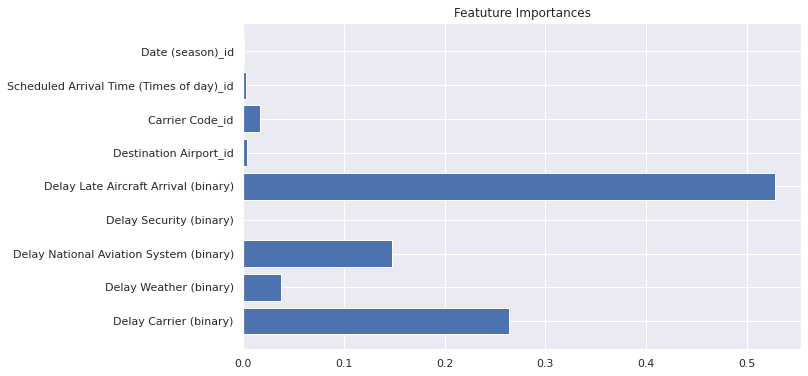

In [94]:
import numpy as np
position = np.arange(9)

fig, ax = plt.subplots()

ax.barh(position, dt_model.featureImportances)
ax.set_yticks(position)
ax.set_yticklabels(new_xcolumns)

fig.set_figwidth(10)
fig.set_figheight(6)
ax.set_title('Featuture Importances')

plt.show()

In [95]:
%%time
new_dt_rmse = dt_evaluator.evaluate(new_dt_predictions)
print('RMSE: {}'.format(new_dt_rmse))

RMSE: 29.60143505401128
CPU times: user 5.14 ms, sys: 3.34 ms, total: 8.47 ms
Wall time: 43.2 s
